# Cloud Datensätze Amazon

Es gibt zahlreiche Datensätze in der Cloud. Leider sind (noch) nicht alle Datensätze frei verfügbar, zudem muss man gegebenenfalls Gebühren für Cloud Speicher bezahlen, oder braucht auch ein Konto (Google Earth Engine) um Daten herunterzuladen. 

* https://aws.amazon.com/earth/
* https://developers.google.com/earth-engine/datasets/catalog


Aber zunächst schauen wir uns scikit image an

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import rasterio
import geoutils
from skimage import data
import os

 # standard font is small, this is not really necessary, but for this presentation better
matplotlib.rcParams['font.size'] = 14

In [2]:
dataset = rasterio.open('daten/world.tif')

if dataset:
    print("File ready", dataset.width, dataset.height, dataset.crs)

File ready 2048 1024 None


In [3]:
r = dataset.read(1)
g = dataset.read(2)
b = dataset.read(3)

bluemarble = np.dstack((r,g,b))  # stack RGB

## Gamma Korrektur

Formel:

${\displaystyle V_{\text{out}}={V_{\text{in}}^{\gamma }}}$



Gamma Korrektur hellt Farben auf (0.5,0,0) wird z.B. zu (0.7,0,0) mit Wurzelfunktion?

In [4]:
from skimage import exposure

#### Plotting Funktion

Funktion um 2 Bilder nebeneinander zu plotten:

In [5]:
def do_plot2(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 10 ))
    ax = axes.ravel()

    ax[0].imshow(image1)
    ax[0].set_title("Bild 1")

    ax[1].imshow(image2)
    ax[1].set_title("Bild 2")

    fig.tight_layout()
    plt.show()

In [6]:
gamma_corrected = exposure.adjust_gamma(bluemarble, 0.4)

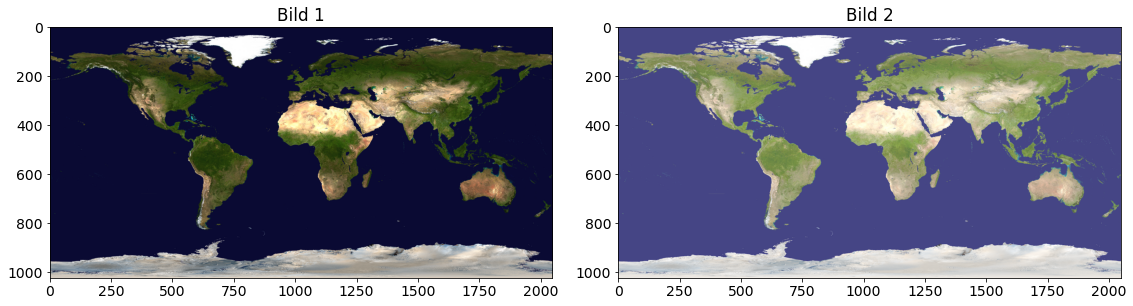

In [7]:
do_plot2(bluemarble, gamma_corrected)

In [8]:
logarithmic_corrected = exposure.adjust_log(bluemarble, 0.5)

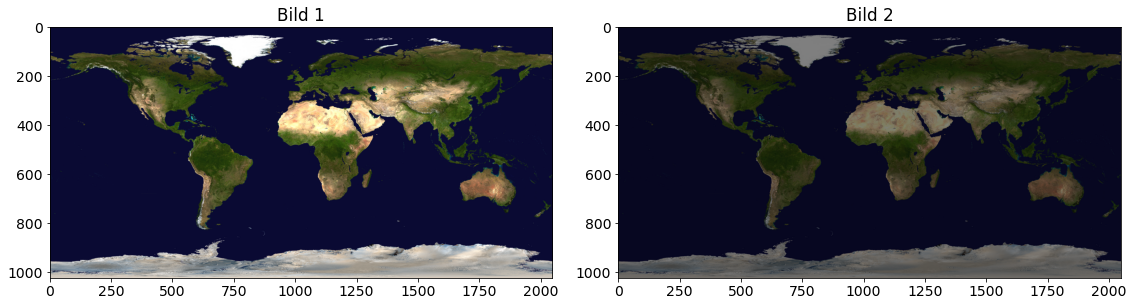

In [9]:
do_plot2(bluemarble, logarithmic_corrected)

## Landsat 8

Landsat 8 orbits the the Earth in a sun-synchronous, near-polar orbit, at an altitude of 705 km (438 mi), inclined at 98.2 degrees, and completes one Earth orbit every 99 minutes.  The satellite has a 16-day repeat cycle with an equatorial crossing time: 10:00 a.m. +/- 15 minutes.  

Landsat 8 aquires about 740 scenes a day on the Worldwide Reference System-2 (WRS-2) path/row system, with a swath overlap (or sidelap) varying from 7 percent at the equator to a maximum of approximately 85 percent at extreme latitudes. A Landsat 8 scene size is 185 km x 180 km (114 mi x 112 mi).

Links:
* https://www.usgs.gov/core-science-systems/nli/landsat/landsat-8
* https://www.usgs.gov/land-resources/nli/landsat

### Landsat Raster Bands


<img src="https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/Landsat%208%20band%20designations.jpg" width="40%"></img>

### Einfacher Download von der Amazon Cloud

* https://docs.opendata.aws/landsat-pds/readme.html


Let's download the scene list, it is around 20 MB download. We can do downloads directly in pandas. Drawback is of course we don't have a nice progress bar.

In [10]:
import pandas as pd

s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')

In [11]:
s3_scenes.shape

(2390885, 12)

In [12]:
s3_scenes.head()

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...
3,LC08_L1TP_012010_20170411_20170415_01_T1,LC80120102017101LGN00,2017-04-11 15:18:14.918879,0.02,L1TP,12,10,69.67856,-56.04655,72.02949,-48.71678,https://s3-us-west-2.amazonaws.com/landsat-pds...
4,LC08_L1TP_012011_20170411_20170415_01_T1,LC80120112017101LGN00,2017-04-11 15:18:38.780265,10.65,L1TP,12,11,68.38187,-57.33186,70.76840,-51.13822,https://s3-us-west-2.amazonaws.com/landsat-pds...


### Cleaning up data

über 2 Millionen Szenen...

* Processing Levels containing T2 und R2 are scenes that still need processing. <-- ignorieren
* Wolken (cloudCover) möglichst reduzieren

In [13]:
clean_scenes = s3_scenes[(s3_scenes.cloudCover <= 2) & 
                       (~s3_scenes.productId.str.contains('_T2')) &
                       (~s3_scenes.productId.str.contains('_RT'))]

In [14]:
clean_scenes.shape

(303405, 12)

### Let's search some data

Example: We want all data containing Switzerland (8.539543, 47.378140)

So let's create a query string for that, bounding boxes are in the dataframe

In [15]:
# nur ein Punkt, weil die Kacheln sehr gross sind und die Schweiz eh abdecken mit einem Punkt
HB = (8.539543, 47.378140)
s = f"min_lat < {HB[1]} and max_lat > {HB[1]} and min_lon < {HB[0]} and max_lon > {HB[0]}"

print(s)
# spatial join wäre mit geopandas auch eine Option

min_lat < 47.37814 and max_lat > 47.37814 and min_lon < 8.539543 and max_lon > 8.539543


In [16]:
scenes_hb = clean_scenes.query(s)

In [17]:
scenes_hb.shape

(15, 12)

In [18]:
scenes_hb.head()

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
435360,LC08_L1TP_194027_20180324_20180403_01_T1,LC81940272018083LGN00,2018-03-24 10:09:50.136557,0.99,L1TP,194,27,46.35991,7.92087,48.51046,11.00967,https://s3-us-west-2.amazonaws.com/landsat-pds...
1321370,LC08_L1TP_194027_20130801_20170503_01_T1,LC81940272013213LGN01,2013-08-01 10:12:19.901453,1.32,L1TP,194,27,46.35977,7.92900,48.51053,11.01747,https://s3-us-west-2.amazonaws.com/landsat-pds...
1321381,LC08_L1TP_194027_20140313_20170425_01_T1,LC81940272014072LGN01,2014-03-13 10:10:51.506805,0.89,L1TP,194,27,46.35776,7.88844,48.50745,10.97840,https://s3-us-west-2.amazonaws.com/landsat-pds...
1321417,LC08_L1TP_194027_20160318_20170328_01_T1,LC81940272016078LGN01,2016-03-18 10:10:07.968756,1.04,L1TP,194,27,46.36005,7.90869,48.51034,11.00188,https://s3-us-west-2.amazonaws.com/landsat-pds...
1321426,LC08_L1TP_194027_20160825_20170322_01_T1,LC81940272016238LGN01,2016-08-25 10:10:28.337638,0.51,L1TP,194,27,46.35943,7.94524,48.51068,11.03695,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [19]:
url = []

def do_get(p):
    url.append(p["download_url"])
    
scenes_hb.apply(do_get, axis=1);
url

['https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20180324_20180403_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20140313_20170425_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20160318_20170328_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20160825_20170322_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/195/027/LC08_L1TP_195027_20150424_20170409_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/195/027/LC08_L1TP_195027_20150830_20170405_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20190122_20190205_01_T1/index.html',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/195/027/L

Let's look at one of the files... Bands are stored as separate file

### Downloading Data

First let's create a new directory inside geodata to store our landsat data

In [20]:
if not os.path.exists("daten/landsat8"):
    os.mkdir("daten/landsat8")

A small function to create filenames for each band:

In [21]:
def getBands(url):
    bands = []
    t = url
    t = t.replace("/index.html", "")
    d = t.split("/")
    
    for i in range(1,12):
        bands.append(t + "/" + d[-1] + f"_B{i}.TIF")
    return bands

selected_file = url[1]

getBands(selected_file)

['https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/LC08_L1TP_194027_20130801_20170503_01_T1_B1.TIF',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/LC08_L1TP_194027_20130801_20170503_01_T1_B2.TIF',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/LC08_L1TP_194027_20130801_20170503_01_T1_B3.TIF',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/LC08_L1TP_194027_20130801_20170503_01_T1_B4.TIF',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/LC08_L1TP_194027_20130801_20170503_01_T1_B5.TIF',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194027_20130801_20170503_01_T1/LC08_L1TP_194027_20130801_20170503_01_T1_B6.TIF',
 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/194/027/LC08_L1TP_194

Let's download them all. We could use requests module, but I'm using wget command, that works too.

In [22]:
for i in getBands(selected_file):
    dest = "daten/landsat8/" + i.split("/")[-1]
    geoutils.download(i, dest)

100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# lets generate our stored filenames:

bands = getBands(selected_file)
data = []
for i in bands:
    d = i.split("/")
    data.append("daten/landsat8/"+d[-1])

data

['daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B1.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B2.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B3.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B4.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B5.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B6.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B7.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B8.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B9.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B10.TIF',
 'daten/landsat8/LC08_L1TP_194027_20130801_20170503_01_T1_B11.TIF']

Load bands separately:

In [24]:
blue = data[1]
green = data[2]
red = data[3]

dataset_red = rasterio.open(red)
dataset_green = rasterio.open(green)
dataset_blue = rasterio.open(blue)

r = dataset_red.read(1)
g = dataset_green.read(1)
b = dataset_blue.read(1)

original_transform = dataset_red.transform
original_crs = dataset_red.crs

print(dataset_red.transform)
print(dataset_red.crs)

dataset_red = None
dataset_green = None
dataset_blue = None

| 30.00, 0.00, 420885.00|
| 0.00,-30.00, 5373615.00|
| 0.00, 0.00, 1.00|
EPSG:32632



EPSG Code: http://epsg.io/?q=32632

It is: WGS 84 / UTM zone 32N, Area of use: Between 6°E and 12°E


In [25]:
np.max(r)

65535

In [26]:
r

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

Von 16 Bit auf 8 bit pro Pixel skalieren (alternativ: `img_as_ubyte`)

In [27]:
r = r / 65535.
r = r * 255
g = g / 65535.
g = g * 255
b = b / 65535.
b = b * 255

r = r.astype(np.uint8)
g = g.astype(np.uint8)
b = b.astype(np.uint8)

### Darstellen

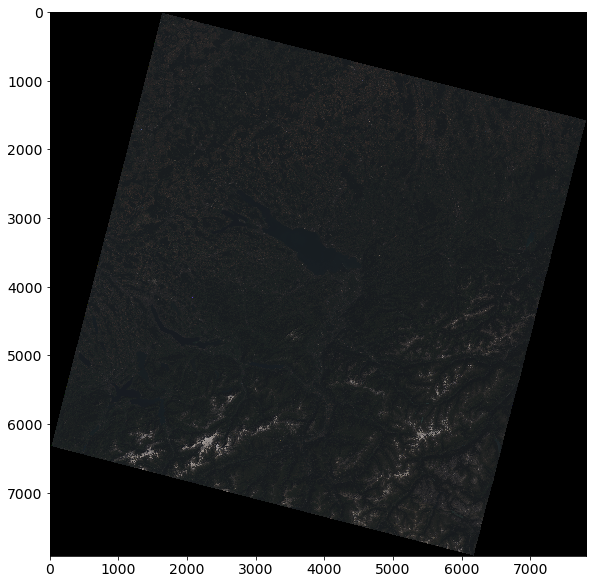

In [28]:
image_rgb = np.dstack((r,g,b)) 
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(image_rgb, interpolation='nearest');
plt.show()

### Farbkorrektur

In [29]:
from skimage import exposure

gamma_corrected = exposure.adjust_gamma(image_rgb, 0.6)

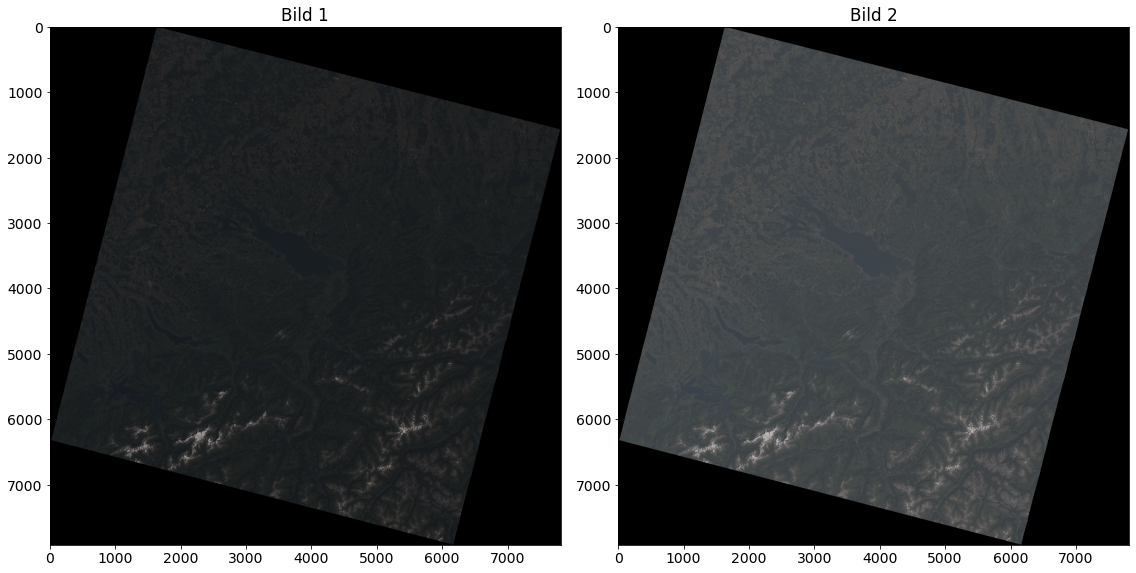

In [30]:
do_plot2(image_rgb, gamma_corrected)

Besser: Intensität ändern 


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/2880px-Standard_deviation_diagram.svg.png" width="50%" />

In [31]:
v_min, v_max = np.percentile(image_rgb, (0.5, 99.5))
better_contrast = exposure.rescale_intensity(image_rgb, in_range=(v_min, v_max))

In [32]:
print(v_min, v_max)

0.0 64.0


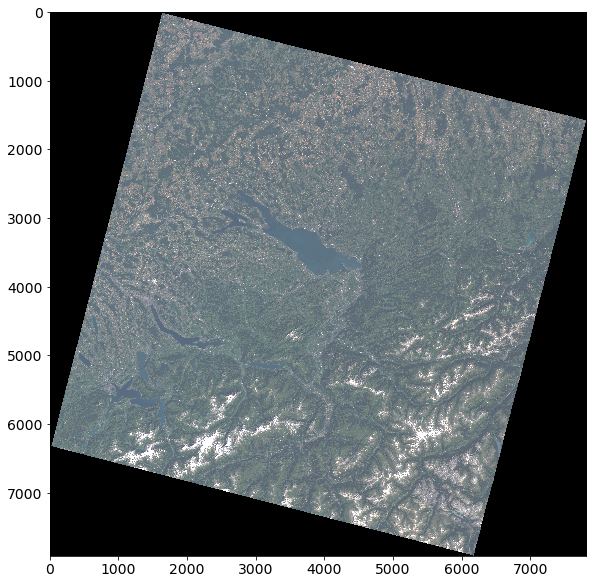

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(better_contrast, interpolation='nearest');
plt.show()

In [34]:
red = better_contrast[:,:,0]  
green = better_contrast[:,:,1] 
blue = better_contrast[:,:,2] 

dataset_out =  rasterio.open("daten/landsat.tif", "w", driver='GTiff', 
                             width=red.shape[0], 
                             height=red.shape[1], 
                             count=3, 
                             dtype=image_rgb.dtype, 
                             crs=original_crs, 
                             transform=original_transform)

dataset_out.write(red, indexes=1)
dataset_out.write(green, indexes=2)
dataset_out.write(blue, indexes=3)

dataset_out = None